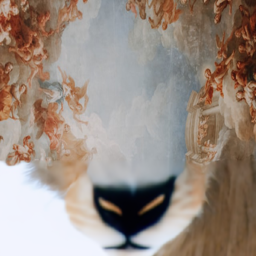




# **Computational Creativity@QMUL**

---


### **Photorealistic Text to Image Generation and Inpainting  With Diffusion based Open AI GLIDE and Guided Text Using CLIP**

**Student Name:** Kumar Sindurakshit

**Student ID:** 200854641

.




---

## **Overview:**
This colab notebook provides  photorealistic text to image generation and inpainting feature guided by text using Open AI diffifusion based generative model guided by Open AI CLIP model.

**Running Notebook:**
1. In colab "Edit" menu  click on "Notebook Settings"  set click Run all and set hardware accelerator  as "GPU"
2. In colab Runtime menu "Run all"  to run all code from top bottom, this will generated an imaged based on the default text.  
3. In "Parameter Selection Sction", guiding text can be changed in by updating text for the "prompt" parameter. In this section operation can be also changed from text generation to in painting by selecting "in_painting". Please note that inpainting will require you to to upload an image file in your colab session and provide name of the image file  for the prameter "upload_image_file_name".  there are other technical parameters to tune model they can be left to defaults or set as desired. 
4. Advanced inpainting section allows you to upload an image file directly and set size and location of mask for inpainting.  

5. Note : You may see some error in bottom cells when you run all, this is nothing to worry, it is because image is not uploaded for inpainting. once image is uploaded and file name updated error will go off.

**Notebook Organization:** 
This note is organised in following sections - 

1.  **Technical Details:** This section provides high level overview of Difficusion based generative models and machine learning pipeline used for this project. 
2.  **Logistics Code:** This section includes code to download pretrained openAI model from my github repository a fork of OpenAI. Just in case if it does not work please uncomment code to download  from open AI github repository.This section also also includes import of various python libraries required for the project. 
3.  **Training Code** 
4.  **Generation Code**
5.  **Interactive Inpainting**

** Proposed Future Improvements:** 

1.   Develop training model based on the paper, requires significant time and compute, also look at the possibility of enhancing algorithm. 
2.   Let it autonomously select text for image generation without human intervation. 
3. Add self evaluation , currentaly model is evaluated based on human perception about image generated, let it evaluate its own output and learn from it.
4. Let it periodically self train itself with new concepts/images 

## **1. Machine Learning Pipeline and Technical Overview**
**1.1 System Design and Architecture:**
Below digram describes system architecture - 
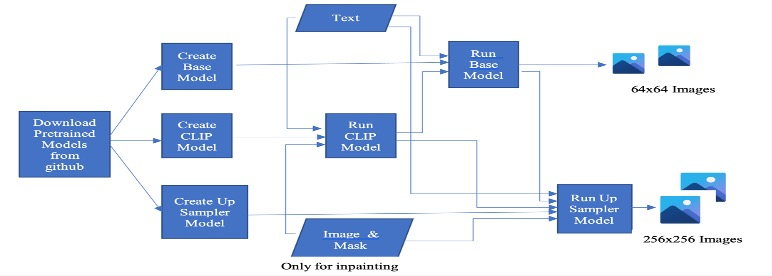
**1.2 CLIP (Contrastive Language–Image Pre-training):**
CLIP builds on a large body of work on zero-shot transfer, natural language supervision, and multimodal learning. The idea of zero-data learning dates back over a decade but until recently was mostly studied in computer vision as a way of generalizing to unseen object categories. 

CLIP pre-trains an image encoder and a text encoder to predict which images were paired with which texts in our dataset. We then use this behavior to turn CLIP into a zero-shot classifier. We convert all of a dataset’s classes into captions such as “a photo of a dog” and predict the class of the caption CLIP estimates best pairs with a given image.
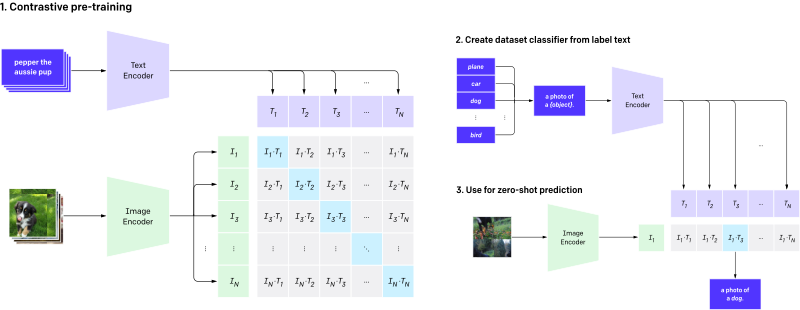
* Image source : https://openai.com

**1.3 GLIDE Guided Language to Image Diffusion for Generation and Editing:**
GLIDEis a 3.5 billion parameter text-to-image generation model created by open AI based on Open AI reserach paper titled, [“GLIDE: Towards Photorealistic Image Generation and Editing with Text-Guided Diffusion Models“](https://arxiv.org/pdf/2112.10741.pdf) the researchers said that they trained the 3.5 billion parameter diffusion model that uses a text encoder to condition on natural language descriptions. 

**GLIDE Training:** As per open researchers model is trained on a 3.5 billion parameter text-conditional diffusion model at 64 × 64 resolution and one more 1.5 billion parameter text-conditional upsampling diffusion model to increase the resolution to 256 × 256. It is a trained a noise-aware 64 × 64 ViT-L CLIP model for CLIP guidance. For text conditioning, it have encoded it into a sequence of K tokens and fed these tokens into a Transformer model. This output is used for two things – the final token embedding is used in place of a class embedding in the ADM model, the last layer of token embeddings separately projected to the dimensionality of each attention layer throughout the ADM model, and then concatenated to the attention context at each layer, as per the paper. 

The model is trained on the same dataset as DALL-E, using the same model architecture. It is scaled to 512 channels and 24 residual blocks of width 2048, used for text encoding, creating 1.2 billion parameters.

**Inpainting:** It is also fine-tuned the model to perform inpainting during which random regions of training examples are erased, and the remaining portions are fed into the model along with a mask channel as additional conditioning information. It use a “trained noise-aware CLIP models with an image encoder fi(xt, t) that receives noised images xt and is otherwise trained with the same objective as the original CLIP model.



## **2. Logistics Code**
This section includes code to download pretrained openAI model from my github repository a fork of OpenAI. Just in case if it does not work please uncomment code to download from open AI github repository.This section also also includes import of various python libraries required for the project. 

In [29]:
# Run this line in Colab to install the package from my github if
# not already installed.
# This includes a pretrained model from openai including clips
!pip install git+https://github.com/sindhurakshit/-diffusion-openai-glide-text2im

# In case you get error, uncomment and run to directly install pretrained model from open AI github
#!pip install git+https://github.com/openai/glide-text2im

  Cloning https://github.com/sindhurakshit/-diffusion-openai-glide-text2im to /tmp/pip-req-build-vpp33ki8
  Running command git clone -q https://github.com/sindhurakshit/-diffusion-openai-glide-text2im /tmp/pip-req-build-vpp33ki8


In [30]:
from typing import Tuple

from IPython.display import display
from PIL import Image
import numpy as np
import torch as th
import torch.nn.functional as F
from glide_text2im.clip.model_creation import create_clip_model
from glide_text2im.tokenizer.simple_tokenizer import SimpleTokenizer


from glide_text2im.download import load_checkpoint
from glide_text2im.model_creation import (
    create_model_and_diffusion,
    model_and_diffusion_defaults,
    model_and_diffusion_defaults_upsampler
)

In [31]:
# This notebook supports both CPU and GPU.
# On CPU, generating one sample may take on the order of 20 minutes.
# On a GPU, it should be under a minute.

has_cuda = th.cuda.is_available()
device = th.device('cpu' if not has_cuda else 'cuda')

## **3.Training Code and Helper Functions**
Open AI Pretrained CLIP and GLIDE models are used so no training. The code in this sections creates base and up sampler models for clip guided difussion text to image generation and inpainting.

In [32]:
# Create base model.
def create_base_model(is_inpaint):
  options = model_and_diffusion_defaults()
  if(is_inpaint):
      options['inpaint'] = True
  options['use_fp16'] = has_cuda
  options['timestep_respacing'] = '100' # use 100 diffusion steps for fast sampling
  model, diffusion = create_model_and_diffusion(**options)
  model.eval()
  if has_cuda:
      model.convert_to_fp16()
  model.to(device)
  if(is_inpaint):
    model.load_state_dict(load_checkpoint('base-inpaint', device))
  else:
    model.load_state_dict(load_checkpoint('base', device))
  print('total base parameters', sum(x.numel() for x in model.parameters()))
  return model, diffusion, options
  

In [33]:
# Create upsampler model.
def create_upsampler_model(is_inpaint):
  options_up = model_and_diffusion_defaults_upsampler()
  if(is_inpaint):
    options_up['inpaint'] = True
  options_up['use_fp16'] = has_cuda
  options_up['timestep_respacing'] = 'fast27' # use 27 diffusion steps for very fast sampling
  model_up, diffusion_up = create_model_and_diffusion(**options_up)
  model_up.eval()
  if has_cuda:
      model_up.convert_to_fp16()
  model_up.to(device)
  if(is_inpaint):
    model_up.load_state_dict(load_checkpoint('upsample-inpaint', device))
  else:
    model_up.load_state_dict(load_checkpoint('upsample', device))
  print('total upsampler parameters', sum(x.numel() for x in model_up.parameters()))
  return model_up , diffusion_up, options_up
  

In [34]:
def show_images(batch: th.Tensor):
    """ Display a batch of images inline. """
    scaled = ((batch + 1)*127.5).round().clamp(0,255).to(th.uint8).cpu()
    reshaped = scaled.permute(2, 0, 3, 1).reshape([batch.shape[2], -1, 3])
    display(Image.fromarray(reshaped.numpy()))

def read_image(path: str, size: int = 256) -> Tuple[th.Tensor, th.Tensor]:
    pil_img = Image.open(path).convert('RGB')
    pil_img = pil_img.resize((size, size), resample=Image.BICUBIC)
    img = np.array(pil_img)
    return th.from_numpy(img)[None].permute(0, 3, 1, 2).float() / 127.5 - 1

In [35]:
def set_images_masks(source_image_64, source_image_256,  x=0, y=40,h=24, b=64):
  # The mask should always be a boolean 64x64 mask, and then we
  # can upsample it for the second stage.
  source_mask_64 = th.ones_like(source_image_64)[:, :1]

  # The mask should always be a boolean 64x64 mask, and then we
  # can upsample it for the second stage.
  source_mask_64[:, :, y:y+h:,x:x+b] = 0
  source_mask_256 = F.interpolate(source_mask_64, (256, 256), mode='nearest')
  return source_mask_64, source_mask_256
  # Visualize the image we are inpainting
  #show_images(source_image_256 * source_mask_256)

In [36]:
##############################
# Sample from the base model #
##############################
def create_inpaint_base_samples(model, diffusion, options,prompt, source_image_64,source_mask_64,batch_size ):
  # Create the text tokens to feed to the model.
  tokens = model.tokenizer.encode(prompt)
  tokens, mask = model.tokenizer.padded_tokens_and_mask(
      tokens, options['text_ctx']
  )

  # Create the classifier-free guidance tokens (empty)
  full_batch_size = batch_size * 2
  uncond_tokens, uncond_mask = model.tokenizer.padded_tokens_and_mask(
      [], options['text_ctx']
  )

  # Pack the tokens together into model kwargs.
  model_kwargs = dict(
      tokens=th.tensor(
          [tokens] * batch_size + [uncond_tokens] * batch_size, device=device
      ),
      mask=th.tensor(
          [mask] * batch_size + [uncond_mask] * batch_size,
          dtype=th.bool,
          device=device,
      ),

      # Masked inpainting image
      inpaint_image=(source_image_64 * source_mask_64).repeat(full_batch_size, 1, 1, 1).to(device),
      inpaint_mask=source_mask_64.repeat(full_batch_size, 1, 1, 1).to(device),
      )


  # Create an classifier-free guidance sampling function
  def model_fn( x_t, ts, **kwargs):
      half = x_t[: len(x_t) // 2]
      combined = th.cat([half, half], dim=0)
      model_out = model(combined, ts, **kwargs)
      eps, rest = model_out[:, :3], model_out[:, 3:]
      cond_eps, uncond_eps = th.split(eps, len(eps) // 2, dim=0)
      half_eps = uncond_eps + guidance_scale * (cond_eps - uncond_eps)
      eps = th.cat([half_eps, half_eps], dim=0)
      return th.cat([eps, rest], dim=1)

  def denoised_fn(x_start):
      # Force the model to have the exact right x_start predictions
      # for the part of the image which is known.
      return (
          x_start * (1 - model_kwargs['inpaint_mask'])
          + model_kwargs['inpaint_image'] * model_kwargs['inpaint_mask']
      )
  #Sample from the base model.
  model.del_cache()
  samples = diffusion.p_sample_loop(
      model_fn,
      (full_batch_size, 3, options["image_size"], options["image_size"]),
      device=device,
      clip_denoised=True,
      progress=True,
      model_kwargs=model_kwargs,
      cond_fn=None,
      denoised_fn=denoised_fn, 
  )[:batch_size]
  model.del_cache()
  return samples

# Show the output
#show_images(create_base_samples(model,model_kwargs, options, diffusion, prompt, samples, source_image_64,source_mask_64,batch_size ))

In [37]:
##############################
# Upsample the 64x64 samples #
##############################
def create_inpaint_upsample(model_up, diffusion_up, options_up, prompt, source_image_256,source_mask_256,batch_size):
  tokens = model_up.tokenizer.encode(prompt)
  tokens, mask = model_up.tokenizer.padded_tokens_and_mask(
      tokens, options_up['text_ctx']
  )
  # Create the model conditioning dict.
  model_kwargs = dict(
      # Low-res image to upsample.
      low_res=((samples+1)*127.5).round()/127.5 - 1,

      # Text tokens
      tokens=th.tensor(
          [tokens] * batch_size, device=device
      ),
      mask=th.tensor(
          [mask] * batch_size,
          dtype=th.bool,
          device=device,
      ),

      # Masked inpainting image.
      inpaint_image=(source_image_256 * source_mask_256).repeat(batch_size, 1, 1, 1).to(device),
      inpaint_mask=source_mask_256.repeat(batch_size, 1, 1, 1).to(device),
  )
   #inner function
  def denoised_fn( x_start):
      # Force the model to have the exact right x_start predictions
      # for the part of the image which is known.
      return (
          x_start * (1 - model_kwargs['inpaint_mask'])
          + model_kwargs['inpaint_image'] * model_kwargs['inpaint_mask']
      )

  # Sample from the base model.
  model_up.del_cache()
  up_shape = (batch_size, 3, options_up["image_size"], options_up["image_size"])
  up_samples = diffusion_up.p_sample_loop(
      model_up,
      up_shape,
      noise=th.randn(up_shape, device=device) * upsample_temp,
      device=device,
      clip_denoised=True,
      progress=True,
      model_kwargs=model_kwargs,
      cond_fn=None,
      denoised_fn=denoised_fn,
  )[:batch_size]
  model_up.del_cache()
  return up_samples

# Show the output
#show_images(create_upsample(model_up, model_kwargs, options_up, diffusion_up, prompt, samples, source_image_256,source_mask_256,batch_size,upsample_temp ))

In [38]:

##############################
# Sample from the base model #
##############################
def create_base_samples(model, clip_model, diffusion, options,prompt,batch_size ):
  # Create the text tokens to feed to the model.
  tokens = model.tokenizer.encode(prompt)
  tokens, mask = model.tokenizer.padded_tokens_and_mask(
      tokens, options['text_ctx']
  )

  # Pack the tokens together into model kwargs.
  model_kwargs = dict(
      tokens=th.tensor([tokens] * batch_size, device=device),
      mask=th.tensor([mask] * batch_size, dtype=th.bool, device=device),
  )

  # Setup guidance function for CLIP model.
  cond_fn = clip_model.cond_fn([prompt] * batch_size, guidance_scale)

  # Sample from the base model.
  model.del_cache()
  samples = diffusion.p_sample_loop(
      model,
      (batch_size, 3, options["image_size"], options["image_size"]),
      device=device,
      clip_denoised=True,
      progress=True,
      model_kwargs=model_kwargs,
      cond_fn=cond_fn,
  )
  model.del_cache()
  return samples

In [39]:
##############################
# Upsample the 64x64 samples #
##############################
def create_upsample(model_up, diffusion_up, options_up, prompt,batch_size):
  tokens = model_up.tokenizer.encode(prompt)
  tokens, mask = model_up.tokenizer.padded_tokens_and_mask(
      tokens, options_up['text_ctx']
  )

  # Create the model conditioning dict.
  model_kwargs = dict(
      # Low-res image to upsample.
      low_res=((samples+1)*127.5).round()/127.5 - 1,

      # Text tokens
      tokens=th.tensor(
          [tokens] * batch_size, device=device
      ),
      mask=th.tensor(
          [mask] * batch_size,
          dtype=th.bool,
          device=device,
      ),
  )

  # Sample from the base model.
  model_up.del_cache()
  up_shape = (batch_size, 3, options_up["image_size"], options_up["image_size"])
  up_samples = diffusion_up.ddim_sample_loop(
      model_up,
      up_shape,
      noise=th.randn(up_shape, device=device) * upsample_temp,
      device=device,
      clip_denoised=True,
      progress=True,
      model_kwargs=model_kwargs,
      cond_fn=None,
  )[:batch_size]
  model_up.del_cache()
  return up_samples

## **4. Text to Image Generation Code**


Creating base model....
total base parameters 385037638

Creating upsampler model....
total upsampler parameters 398368198


Masked Image


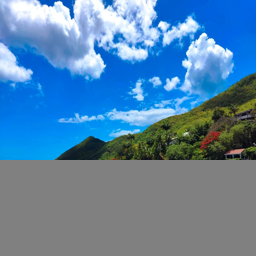


Generating base image...


  0%|          | 0/100 [00:00<?, ?it/s]



Generated base image 


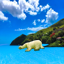


Generating upsampled image...


  0%|          | 0/27 [00:00<?, ?it/s]



Generated upsampled image 


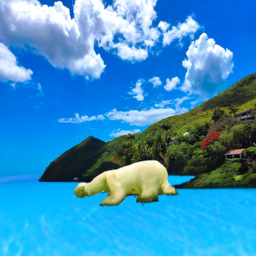

In [46]:
from IPython.core.display import Markdown
#@title  Parameter Selection Section 
# Sampling parameters
#prompt = "sunset"
#batch_size = 1
#guidance_scale = 5.0
in_painting=False
#@title Parameters for Image Generation
select_operation = 'in_painting'#@param ["clip_guided_text_to_image_generation", "in_painting"]

prompt = "A polar bear with fish in its mouth" #@param{type: "string"}

#@markdown Larger batch size willl lead to better perdormance but will take more time.
batch_size = 1 #@param {type:"slider", min:1, max:5, step:1}

#@markdown Guidence scale controls extent of clip guidence, default  value is 3
guidance_scale = 5 #@param {type:"slider", min:3, max:7, step:1}

# Tune this parameter to control the sharpness of 256x256 images.
# A value of 1.0 is sharper, but sometimes results in grainy artifacts.
upsample_temp = 0.997

#@markdown No input needed for text to image, for inpainting please upload an image file in in your current and providei mage name
upload_image_file_name ="paint1.jpg"#@param{type: "string"}


if(select_operation=='in_painting'):
  in_painting=True
else:
  in_painting=False

#create models
print("Creating base model....")
model, diffusion, options =create_base_model(in_painting)
print("\nCreating upsampler model....")
model_up, diffusion_up, options_up=create_upsampler_model(in_painting)

if(in_painting):
  #Source image we are inpainting
  source_image_64 = read_image(upload_image_file_name, size=64)
  source_image_256 = read_image(upload_image_file_name, size=256)
  source_mask_64, source_mask_256=set_images_masks(source_image_64, source_image_256)

  # Visualize the image we are inpainting
  print("\n\nMasked Image")
  show_images(source_image_256 * source_mask_256)

  #run base sample
  print("\nGenerating base image...")
  samples=create_inpaint_base_samples(model, diffusion,options, prompt, source_image_64,source_mask_64,batch_size )
  print("\n\nGenerated base image ")
  show_images(samples)

  # run upsamplers 
  print("\nGenerating upsampled image...")
  up_samples=create_inpaint_upsample(model_up, diffusion_up,options_up, prompt, source_image_256,source_mask_256,batch_size)
  print("\n\nGenerated upsampled image ")
  show_images(up_samples)
else:
  #run base sample
  print("\nGenerating base image...")
  clip_model = create_clip_model(device=device)
  clip_model.image_encoder.load_state_dict(load_checkpoint('clip/image-enc', device))
  clip_model.text_encoder.load_state_dict(load_checkpoint('clip/text-enc', device))
  samples=create_base_samples(model,clip_model, diffusion,options, prompt,batch_size )
  print("\n\nGenerated base image ")
  show_images(samples)

  # run upsamplers 
  print("\nGenerating upsampled image...")
  up_samples=create_upsample(model_up, diffusion_up, options_up, prompt,batch_size)
  print("\n\nGenerated upsampled image ")
  show_images(up_samples)

  


 ## **5. Interactive Inpainting:** 
This section implements jupyter widgets for interactive image inpainting by allowing users to upload images from there local drive , change position and size of the mask for inpainting and then do the inpainting with click of bution.

**There is bug in the system where it menorises inpainted model output from the previous run puts pixels from the sample in subsequent run**.

In [49]:
import ipywidgets as widgets
from PIL import Image 
from ipywidgets import interact, interactive


def  image2numpy(img, size: int = 256) -> Tuple[th.Tensor, th.Tensor]:
    pil_img = img.resize((size, size), resample=Image.BICUBIC)
    img = np.array(pil_img)
    return th.from_numpy(img)[None].permute(0, 3, 1, 2).float() / 127.5 - 1

def select_image_file():
  uploader = widgets.FileUpload(
      accept='image/*',  
      multiple=False  
  )
  display(uploader)
  return uploader

uploader=select_image_file()


FileUpload(value={}, accept='image/*', description='Upload')

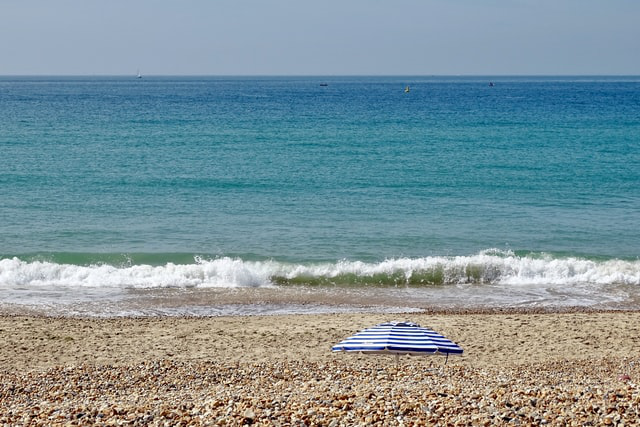

In [50]:
import io
for name, file_info in uploader.value.items():
  img = Image.open(io.BytesIO(file_info['content']))
  display(img)

interactive(children=(IntSlider(value=25, continuous_update=False, description='x position', max=50), IntSlide…

Label(value='Please enter your guiding text')

Text(value='')

Button(description='Create Inpainting', style=ButtonStyle())

Output()



Masked Image


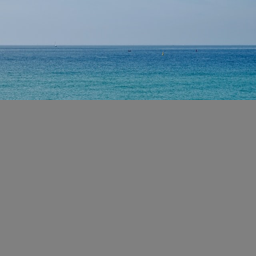

Creating base model....
total base parameters 385037638

Creating upsampler model....
total upsampler parameters 398368198
Text Prompt is A walking penguin

Generating base image...


  0%|          | 0/100 [00:00<?, ?it/s]



Generated base image 


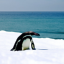


Generating upsampled image...


  0%|          | 0/27 [00:00<?, ?it/s]



Generated upsampled image 


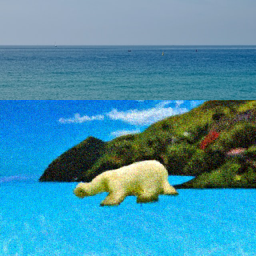

In [51]:
has_cuda = th.cuda.is_available()
device = th.device('cpu' if not has_cuda else 'cuda')
batch_size = 1
guidance_scale = 6


# Tune this parameter to control the sharpness of 256x256 images.
# A value of 1.0 is sharper, but sometimes results in grainy artifacts.
upsample_temp = 0.997


def mask_show( x=20, y=20,h=20, b=20):
 # Source image we are inpainting
  isource_image_256 = image2numpy(img, size=256)
  isource_image_64 = image2numpy(img, size=64)

  # The mask should always be a boolean 64x64 mask, and then we
  # can upsample it for the second stage.
  isource_mask_64 = th.ones_like(isource_image_64)[:, :1]

  isource_mask_64[:, :, y:y+h:,x:x+b] = 0
  isource_mask_256 = F.interpolate(isource_mask_64, (256, 256), mode='nearest')

  # Visualize the image we are inpainting
  show_images(isource_image_256 * isource_mask_256)
  return isource_image_256, isource_image_64, isource_mask_64, isource_mask_256
w = interactive(mask_show,
               x =widgets.IntSlider(min=0, max=50, value=25, description = 'x position',continuous_update=False),
               y=widgets.IntSlider(min=0, max=50, value=25, description = 'y position',continuous_update=False), 
               h=widgets.IntSlider(min=15, max=64, value=25, description = 'Height',continuous_update=False),
               b=widgets.IntSlider(min=15, max=64, value=25, description = 'Width',continuous_update=False),
               description="Select mask position and size")
display(w)
lbl= widgets.Label("Please enter your guiding text")
print("\n")
display(lbl)
prompt=widgets.Text()
display(prompt)
button = widgets.Button(description="Create Inpainting")
output = widgets.Output()
display(button, output)

def on_button_clicked(b):
  isource_image_256, isource_image_64, isource_mask_64, isource_mask_256=w.result
  #show_images(source_image_256)
  #show_images(source_image_64)
  print("\n\nMasked Image")
  show_images(isource_image_256 * isource_mask_256)
  #create models
  print("Creating base model....")
  model2, diffusion2, options2 =create_base_model(True)
  print("\nCreating upsampler model....")
  model_up2, diffusion_up2, options_up2=create_upsampler_model(True)
  print("Text Prompt is " + prompt.value)
  #run base sample
  print("\nGenerating base image...")
  samples2=create_inpaint_base_samples(model2, diffusion2,options2, prompt.value, isource_image_64,isource_mask_64,batch_size )
  print("\n\nGenerated base image ")
  show_images(samples2)

  # run upsamplers 
  print("\nGenerating upsampled image...")
  up_samples2=create_inpaint_upsample(model_up2, diffusion_up2,options_up2, prompt.value, isource_image_256,isource_mask_256,batch_size)
  print("\n\nGenerated upsampled image ")
  show_images(up_samples2)

button.on_click(on_button_clicked)